Today, we worked as a team to predict Alibaba Group's stock prices using historical data (2014-2025) with time series models (ARIMA, SARIMA, LSTM, and RNN). We collected data using the Yahoo Finance API (yfinance) and followed these steps:

1. **Data Collection:** Loaded the dataset with pandas and preprocessed it.
2. **Data Cleaning:** Handled missing values, removed duplicates, and filtered out negative stock prices.
3. **Exploratory Data Analysis (EDA):** Visualized the closing price of the stock over time.
4. **Model Building:** Implemented ARIMA, SARIMA, LSTM, and RNN models for price prediction.
5. **Model Evaluation:** Used MAE and RMSE to evaluate model performance.

## Dataset
[Alibaba Stock Dataset - Kaggle](https://www.kaggle.com/datasets/mhassansaboor/alibaba-stock-dataset-2025?select=Ali_Baba_Stock_Data.csv)

## Model Evaluation

| Model   | MAE   | RMSE  |
|---------|-------|-------|
| ARIMA   | 29.35 | 31.25 |
| SARIMA  | 21.88 | 23.83 |
| LSTM    | 2.33  | 3.30  |
| RNN     | 2.05  | 2.61  |

The results show that LSTM and RNN performed the best, with lower MAE and RMSE values than ARIMA and SARIMA.


# 1. Importing Libraries

In [13]:
import seaborn as sns

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# 2. Data Collection, Cleaning and Preprocessing

In [16]:
df = pd.read_csv("Ali_Baba_Stock_Data.csv")

In [17]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2014-09-19,90.673950,93.889999,99.699997,89.949997,92.699997,271879400
1,2014-09-22,86.810966,89.889999,92.949997,89.500000,92.699997,66657800
2,2014-09-23,84.184128,87.169998,90.480003,86.620003,88.940002,39009800
3,2014-09-24,87.467667,90.570000,90.570000,87.220001,88.470001,32088000
4,2014-09-25,85.874191,88.919998,91.500000,88.500000,91.089996,28598000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2617 entries, 0 to 2616
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2617 non-null   object 
 1   Adj Close  2617 non-null   float64
 2   Close      2617 non-null   float64
 3   High       2617 non-null   float64
 4   Low        2617 non-null   float64
 5   Open       2617 non-null   float64
 6   Volume     2617 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 143.2+ KB


In [19]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [20]:
df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2014-09-19,90.673950,93.889999,99.699997,89.949997,92.699997,271879400
2014-09-22,86.810966,89.889999,92.949997,89.500000,92.699997,66657800
2014-09-23,84.184128,87.169998,90.480003,86.620003,88.940002,39009800
2014-09-24,87.467667,90.570000,90.570000,87.220001,88.470001,32088000
2014-09-25,85.874191,88.919998,91.500000,88.500000,91.089996,28598000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2617 entries, 2014-09-19 to 2025-02-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2617 non-null   float64
 1   Close      2617 non-null   float64
 2   High       2617 non-null   float64
 3   Low        2617 non-null   float64
 4   Open       2617 non-null   float64
 5   Volume     2617 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 143.1 KB


In [22]:
df.isnull().sum()

Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64

In [23]:
# Check for duplicates
df = df.drop_duplicates()

In [24]:
# Verify date format and handle outliers (if necessary)
df = df[df['Close'] > 0]  # Filtering out rows with negative stock prices

# 3. Exploratory Data Analysis (EDA)

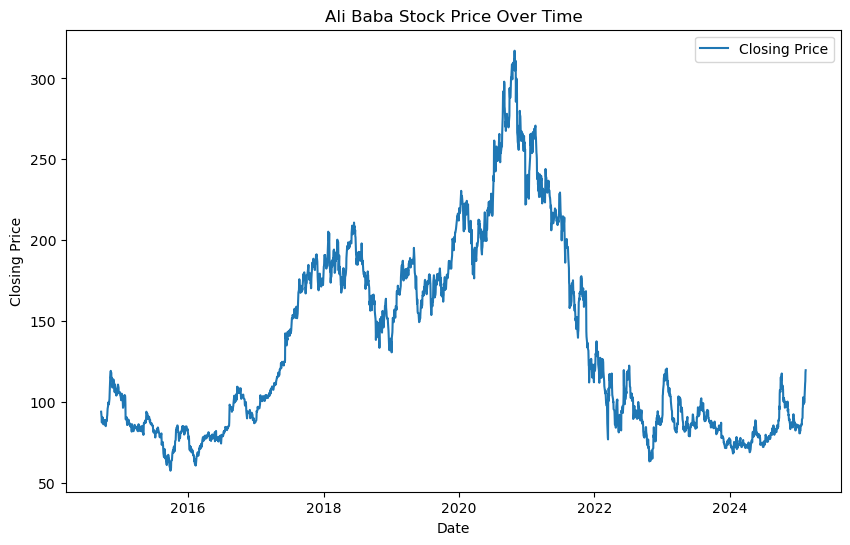

In [26]:
# Visualizing stock price over time
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Closing Price')
plt.title("Ali Baba Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.show()


## Alibaba Stock Price Trend Analysis

#### Key Observations:
- Alibaba's stock price showed a **significant uptrend from 2016 to 2020**, reaching a peak above **300 USD** in late 2020.
- A **sharp decline followed after 2021**, bringing the stock price back to near 2016 levels.
- **Recent movements in 2024** suggest a potential **recovery phase**.
- This trend reflects broader market conditions, regulatory challenges, and company-specific factors.

<Axes: >

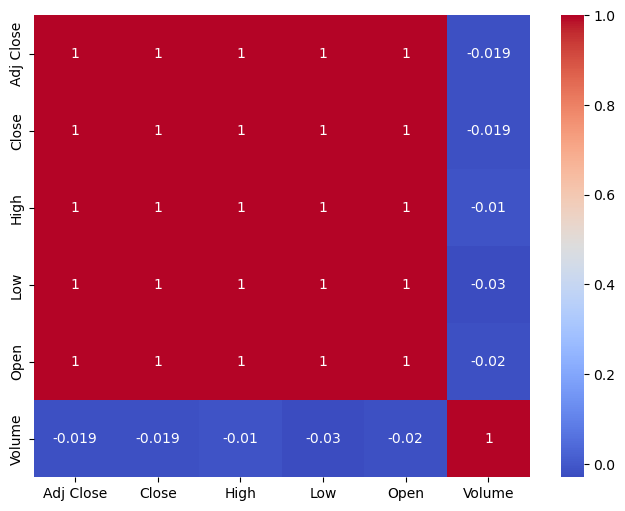

In [27]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

## Alibaba Stock Price Correlation Analysis

#### Key Insights:
- **Closing Price, High, Low, Open, and Adjusted Close** have a **perfect correlation (1.0)**, meaning they move in sync.
- **Trading Volume has negligible correlation** with price variables (-0.01 to -0.03).
- This suggests that **price fluctuations are not significantly influenced by trading volume**.
- Investors should analyze other factors, such as market sentiment and economic conditions, to understand Alibaba's price movements.

In [28]:
# Suppress all warnings
warnings.filterwarnings('ignore')


# 4. Model Building


In [30]:
# Selecting the target variable
series = df['Close']

In [31]:
# Train-test split
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]


In [32]:
# ARIMA Model
arima_model = ARIMA(train, order=(5,1,2))
arima_result = arima_model.fit()
arima_pred = arima_result.forecast(len(test))

In [33]:
# SARIMA Model
sarima_model = SARIMAX(train, order=(5,1,2), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()
sarima_pred = sarima_result.forecast(len(test))

In [34]:
# LSTM Model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(np.array(train).reshape(-1, 1))
scaled_test = scaler.transform(np.array(test).reshape(-1, 1))

In [35]:
# Create sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(scaled_test, seq_length)

In [36]:
# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [37]:
# Build LSTM model
lstm_model = Sequential([ 
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

In [38]:
# Train LSTM model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0567
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 9.2427e-04
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.6657e-04
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.6819e-04
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.1853e-04
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.7290e-04
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 6.9867e-04
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.6483e-04
Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.8498e-04
Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.0660e-04
Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.3912e-04
Epoch 12/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.4788e-04
Epoch 13/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4.3980e-04
Epoch 14/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 4

In [39]:
# Predict using LSTM
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


In [40]:
# RNN Model
# Build RNN model
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    SimpleRNN(50, activation='relu'),
    Dense(1)
])
rnn_model.compile(optimizer='adam', loss='mse')

In [41]:
# Train RNN model
rnn_model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0500
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4879e-04
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.9549e-04
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5873e-04
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.8767e-04
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.0503e-04
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1489e-04
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7267e-04
Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0951e-04
Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5104e-04
Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7173e-04
Epoch 12/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.8135e-04
Epoch 13/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6414e-04
Epoch 14/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1891e-04
E

In [42]:
# Predict using RNN
rnn_pred = rnn_model.predict(X_test)
rnn_pred = scaler.inverse_transform(rnn_pred)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


In [43]:
# Convert test sets to comparable formats
arima_pred = np.array(arima_pred)
sarima_pred = np.array(sarima_pred)

# 5. Model Evaluation

In [45]:
# Evaluate models
print("Model Evaluation Results:")
print("\nARIMA MAE:", mean_absolute_error(test, arima_pred))
print("SARIMA MAE:", mean_absolute_error(test, sarima_pred))
print("LSTM MAE:", mean_absolute_error(test[seq_length:], lstm_pred.flatten()))
print("RNN MAE:", mean_absolute_error(test[seq_length:], rnn_pred.flatten()))

Model Evaluation Results:

ARIMA MAE: 29.35142209573023
SARIMA MAE: 21.883125290855055
LSTM MAE: 2.194735709474556
RNN MAE: 2.2208458429563622


## Model Evaluation - Mean Absolute Error (MAE)

#### Results:
- **ARIMA MAE:** 29.35  
- **SARIMA MAE:** 21.88  
- **LSTM MAE:** 2.19  
- **RNN MAE:** 2.22  

#### Insights:
- **LSTM and RNN have the lowest MAE**, indicating better prediction accuracy.
- **SARIMA performs better than ARIMA**, but still has a significantly higher MAE than LSTM and RNN.
- **ARIMA shows the highest MAE**, meaning it has the largest average error in predictions.


In [46]:
# RMSE for all models
print("ARIMA RMSE:", np.sqrt(mean_squared_error(test, arima_pred)))
print("SARIMA RMSE:", np.sqrt(mean_squared_error(test, sarima_pred)))
print("LSTM RMSE:", np.sqrt(mean_squared_error(test[seq_length:], lstm_pred.flatten())))
print("RNN RMSE:", np.sqrt(mean_squared_error(test[seq_length:], rnn_pred.flatten())))

ARIMA RMSE: 31.254530493233677
SARIMA RMSE: 23.82999536782558
LSTM RMSE: 2.988248988347413
RNN RMSE: 2.7675132425330666


## Model Evaluation - Root Mean Squared Error (RMSE)

#### Results:
- **ARIMA RMSE:** 31.25  
- **SARIMA RMSE:** 23.83  
- **LSTM RMSE:** 2.99  
- **RNN RMSE:** 2.77  

#### Insights:
- **LSTM and RNN again outperform traditional models (ARIMA & SARIMA)** with much lower RMSE.
- **RNN has the lowest RMSE (2.77), followed closely by LSTM (2.99)**, indicating strong predictive power.
- **SARIMA improves over ARIMA**, but still performs worse than deep learning models.
- **ARIMA has the highest RMSE**, suggesting it struggles with precise stock price predictions.


# 6. Visualization

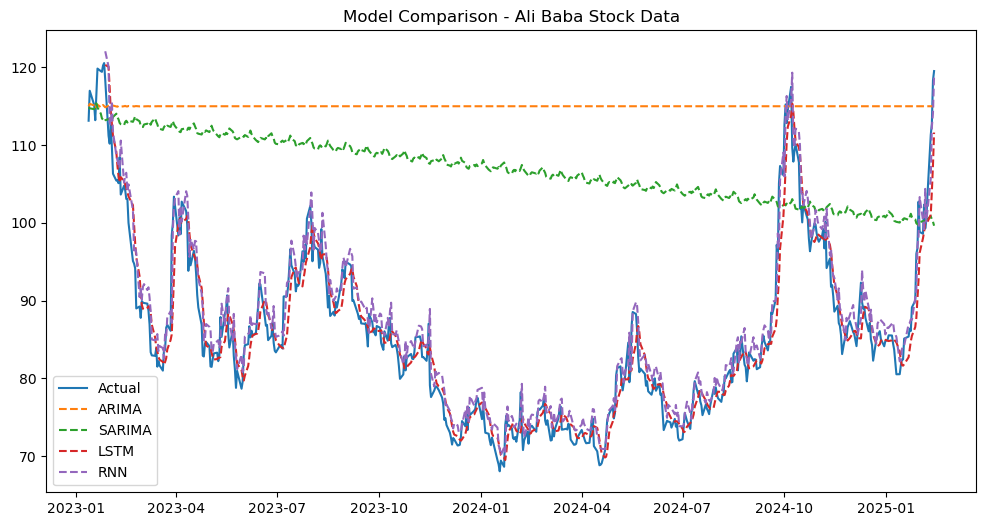

In [48]:
# Plot the comparison of all models' predictions
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, arima_pred, label="ARIMA", linestyle='dashed')
plt.plot(test.index, sarima_pred, label="SARIMA", linestyle='dashed')
plt.plot(test.index[seq_length:], lstm_pred, label="LSTM", linestyle='dashed')
plt.plot(test.index[seq_length:], rnn_pred, label="RNN", linestyle='dashed')
plt.legend()
plt.title("Model Comparison - Ali Baba Stock Data")
plt.show()

## Model Comparison - Alibaba Stock Data

#### Key Observations:
- The **Actual stock price (blue line)** shows a highly volatile trend with frequent ups and downs.
- **LSTM (red dashed line) and RNN (purple dashed line) closely follow the actual trend**, indicating strong predictive capabilities.
- **ARIMA (orange dashed line) remains mostly flat**, failing to capture the stock's fluctuations.
- **SARIMA (green dashed line) shows a slight downward trend**, but it doesn't capture volatility well.

#### Insights:
- **LSTM and RNN outperform ARIMA and SARIMA**, as seen in their ability to track stock movements accurately.
- **ARIMA struggles with dynamic changes**, making it less suitable for volatile stock data.
- **SARIMA performs slightly better than ARIMA**, but it still lags behind deep learning models.
- **Deep learning models (LSTM & RNN) are the best choices** for Alibaba stock price prediction based on this visualization.

#### Recommendations:
- For short-term stock price forecasting, **LSTM and RNN should be preferred** due to their ability to capture trends and fluctuations.
- **ARIMA and SARIMA might work better for stable, long-term trends**, but they are not ideal for volatile stocks like Alibaba.
